# Nama : Elsa Elisa Yohana Sianturi
# NIM : 122140135

# Install Library

In [1]:
!pip install timm seaborn tqdm


# Import Library

In [2]:
import os
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


# Import library PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

# Cek  GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU terdeteksi:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU tidak tersedia, menggunakan CPU")

device

GPU terdeteksi: Tesla T4


device(type='cuda')

# Load dataset & encode label

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   filename      label
0  0001.jpg  gado_gado
1  0002.jpg  gado_gado
2  0003.jpg    rendang
3  0004.jpg      bakso
4  0005.jpg      bakso


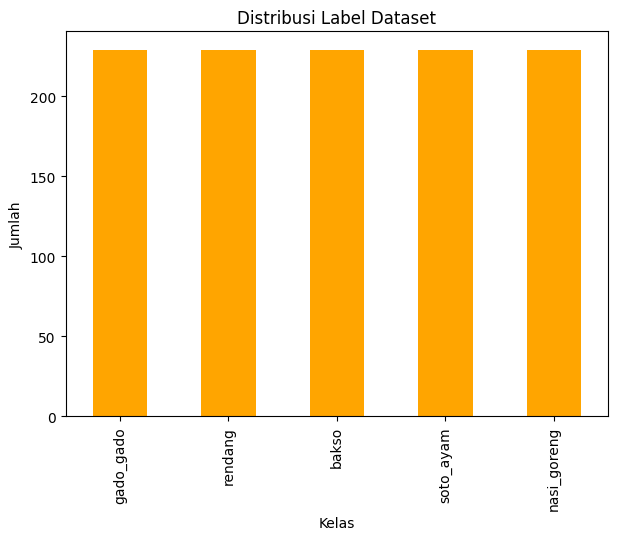

Jumlah Data Train: 916
Jumlah Data Validasi: 229
Persentase Data Train     : 80.00%
Persentase Data Validasi  : 20.00%


5

In [3]:
from google.colab import drive
drive.mount('/content/drive')

csv_path = "/content/drive/MyDrive/Tugas2/label.csv"
img_dir  = "/content/drive/MyDrive/Tugas2/dataset/"
df = pd.read_csv(csv_path)
print(df.head())

# Visualisasi distribusi kelas
plt.figure(figsize=(7,5))
df['label'].value_counts().plot(kind='bar', color='orange')
plt.title("Distribusi Label Dataset")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

# Encode label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Split train dan validation
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded']
)

print("Jumlah Data Train:", len(train_df))
print("Jumlah Data Validasi:", len(val_df))

# Hitung persentase
total = len(df)
train_percent = (len(train_df) / total) * 100
val_percent   = (len(val_df) / total) * 100

print(f"Persentase Data Train     : {train_percent:.2f}%")
print(f"Persentase Data Validasi  : {val_percent:.2f}%")

num_classes = len(label_encoder.classes_)
num_classes


# Class Dataset dan Augmentasi

In [4]:
# Class dataset custom untuk membaca gambar & label
class FoodDataset(Dataset):
    # Dataset ini menerima dataframe, folder gambar, dan transformasi
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    # Mengambil satu data: gambar + label
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])

        # Baca gambar sebagai RGB (untuk model transformer)
        image = Image.open(img_path).convert("RGB")
        label = row['label_encoded']

        # Jika ada augmentasi maka terapkan
        if self.transform:
            image = self.transform(image)

        return image, label


# Augmentasi untuk training
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# Transformasi validasi (tanpa augmentasi)
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# Membuat dataset & loader
train_ds = FoodDataset(train_df, img_dir, train_tf)
val_ds   = FoodDataset(val_df, img_dir, val_tf)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)


# Konfigurasi training

In [5]:
# hyper parameter yang dibutuhkan
config = {
    "epochs": 12,
    "lr": 1e-4,
    "batch_size": 16,
    "patience": 3, # untuk early stopping
    "device": device,
    "save_path": "/content/drive/MyDrive/Tugas2/result/"
}

# Membuat folder hasil jika belum ada
os.makedirs(config["save_path"], exist_ok=True)

config


{'epochs': 12,
 'lr': 0.0001,
 'batch_size': 16,
 'patience': 3,
 'device': device(type='cuda'),
 'save_path': '/content/drive/MyDrive/Tugas2/result/'}

# Load Model

In [7]:
# fungsi untuk parameter
def count_params(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

# Load model Swin Tiny
model_swin = timm.create_model(
    "swin_tiny_patch4_window7_224",
    pretrained=True,
    num_classes=num_classes
)

# Freeze semua layer kecuali head
for name, param in model_swin.named_parameters():
    param.requires_grad = "head" in name

print("Trainable Swin")
print(count_params(model_swin))


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Trainable Swin
(3845, 27523199)


# Fungsi Training dan early stopping

In [8]:
def train_model(model, train_loader, val_loader, config, model_name):
    model.to(config["device"])

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config["lr"]
    )

    best_loss = float("inf")
    patience_counter = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    for epoch in range(config["epochs"]):
        model.train()
        train_loss, correct_train = 0, 0

        print(f"\nEpoch {epoch+1}/{config['epochs']}")

        #  Progress bar untuk TRAINING
        for x, y in tqdm(train_loader, desc=f"Training {model_name}"):
            x, y = x.to(config["device"]), y.to(config["device"])

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct_train += (outputs.argmax(1) == y).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct_train / len(train_loader.dataset)


        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"Validation {model_name}"):
                x, y = x.to(config["device"]), y.to(config["device"])
                outputs = model(x)
                val_loss += criterion(outputs, y).item()
                correct_val += (outputs.argmax(1) == y).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct_val / len(val_loader.dataset)

        # Simpan history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"[{model_name}] TrainLoss={train_loss:.4f} ValLoss={val_loss:.4f} "
              f"TrainAcc={train_acc:.4f} ValAcc={val_acc:.4f}")

        # SImpan model
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"{config['save_path']}/{model_name}_best.pth")
            print(f"Model terbaik {model_name} disimpan!")
        else:
            patience_counter += 1

        if patience_counter >= config["patience"]:
            print("Early stopping aktif!")
            break

    return model, history


# Training Model

In [11]:
history_dict = {}
model_swin, hist_cait = train_model(model_swin, train_loader, val_loader, config, "swin")
history_dict["swin"] = hist_cait


Epoch 1/12


Training swin:  57%|█████▋    | 33/58 [00:20<00:11,  2.17it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation swin: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


[swin] TrainLoss=1.5350 ValLoss=1.3516 TrainAcc=0.3373 ValAcc=0.6114
Model terbaik swin disimpan!

Epoch 2/12


Validation swin: 100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


[swin] TrainLoss=1.2417 ValLoss=1.1030 TrainAcc=0.6692 ValAcc=0.7860
Model terbaik swin disimpan!

Epoch 3/12


Validation swin: 100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


[swin] TrainLoss=1.0420 ValLoss=0.9289 TrainAcc=0.7751 ValAcc=0.8472
Model terbaik swin disimpan!

Epoch 4/12


Validation swin: 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


[swin] TrainLoss=0.9047 ValLoss=0.8061 TrainAcc=0.8286 ValAcc=0.8734
Model terbaik swin disimpan!

Epoch 5/12


Validation swin: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


[swin] TrainLoss=0.7907 ValLoss=0.7161 TrainAcc=0.8712 ValAcc=0.8996
Model terbaik swin disimpan!

Epoch 6/12


Validation swin: 100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


[swin] TrainLoss=0.7024 ValLoss=0.6474 TrainAcc=0.8799 ValAcc=0.8996
Model terbaik swin disimpan!

Epoch 7/12


Validation swin: 100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


[swin] TrainLoss=0.6463 ValLoss=0.5917 TrainAcc=0.8810 ValAcc=0.9039
Model terbaik swin disimpan!

Epoch 8/12


Validation swin: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


[swin] TrainLoss=0.5905 ValLoss=0.5477 TrainAcc=0.9028 ValAcc=0.9083
Model terbaik swin disimpan!

Epoch 9/12


Validation swin: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


[swin] TrainLoss=0.5481 ValLoss=0.5093 TrainAcc=0.9039 ValAcc=0.9083
Model terbaik swin disimpan!

Epoch 10/12


Validation swin: 100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


[swin] TrainLoss=0.5110 ValLoss=0.4801 TrainAcc=0.9159 ValAcc=0.9127
Model terbaik swin disimpan!

Epoch 11/12


Validation swin: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


[swin] TrainLoss=0.4875 ValLoss=0.4528 TrainAcc=0.9083 ValAcc=0.9127
Model terbaik swin disimpan!

Epoch 12/12


Validation swin: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


[swin] TrainLoss=0.4585 ValLoss=0.4294 TrainAcc=0.9138 ValAcc=0.9170
Model terbaik swin disimpan!


# Plot Kurva

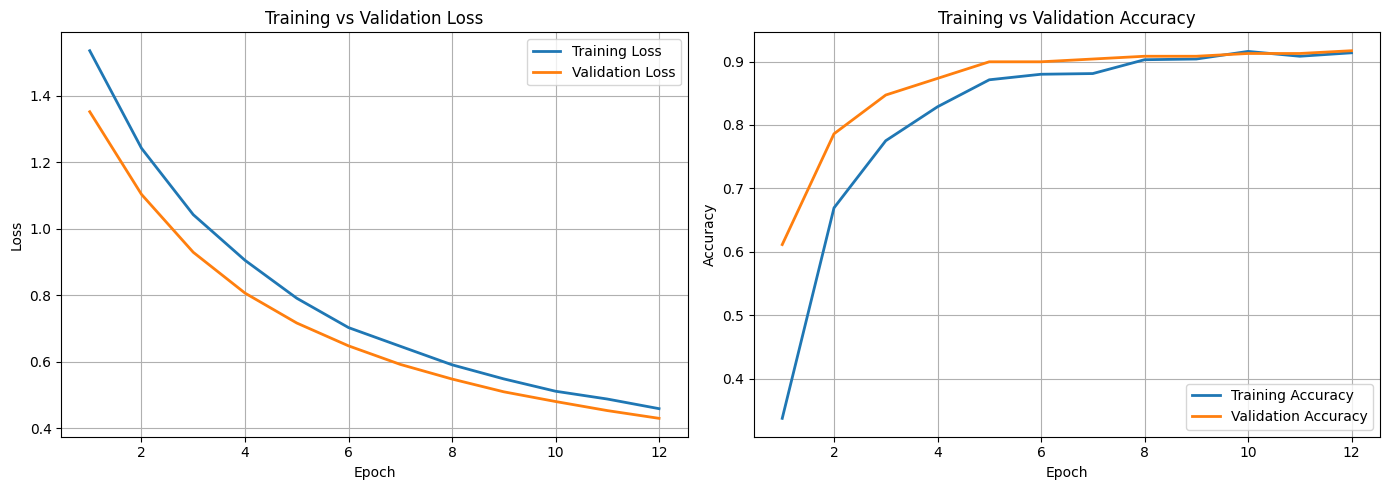

In [13]:
hist = history_dict["swin"]

# Ambil data
train_loss = hist["train_loss"]
val_loss = hist["val_loss"]
train_acc = hist["train_acc"]
val_acc = hist["val_acc"]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))


# Kurva LOSS
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss", linewidth=2)
plt.plot(epochs, val_loss, label="Validation Loss", linewidth=2)
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()


# Kurva ACCURACY
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Training Accuracy", linewidth=2)
plt.plot(epochs, val_acc, label="Validation Accuracy", linewidth=2)
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Evaluasi

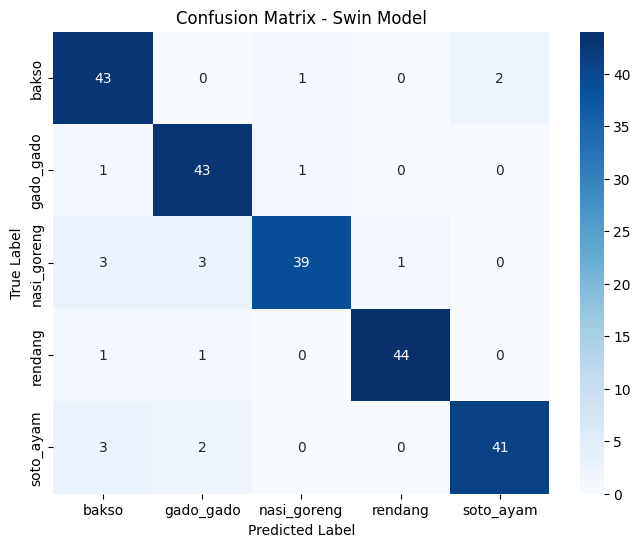

Classification Report:
              precision    recall  f1-score   support

       bakso       0.84      0.93      0.89        46
   gado_gado       0.88      0.96      0.91        45
 nasi_goreng       0.95      0.85      0.90        46
     rendang       0.98      0.96      0.97        46
   soto_ayam       0.95      0.89      0.92        46

    accuracy                           0.92       229
   macro avg       0.92      0.92      0.92       229
weighted avg       0.92      0.92      0.92       229



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#   Confusion matrix

model_swin.eval()
model_swin.to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        outputs = model_swin(x)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# Hitung confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = label_encoder.classes_
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Swin Model")
plt.show()

#  CLASSIFICATION REPORT
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))


# Pengukuran Waktu Interfensi

In [17]:
import time
import numpy as np
from tqdm import tqdm
from PIL import Image

def measure_inference_swin(model, model_name="swin", n_samples=100):

    # Pengambilan sampel acak dari validation set
    sample_df = val_df.sample(min(n_samples, len(val_df)))
    times = []
    model.eval()

    with torch.no_grad():
        # Loop setiap gambar
        for _, row in tqdm(sample_df.iterrows(),
                           total=len(sample_df),
                           desc=f"Inference {model_name}",
                           leave=True):

            # Load gambar
            img = Image.open(os.path.join(img_dir, row["filename"])).convert("RGB")
            img = val_tf(img).unsqueeze(0).to(device)

            # Jalankan inferensi & hitung waktu
            start = time.time()
            _ = model(img)
            end = time.time()

            times.append(end - start)

    # Waktu rata-rata per gambar (dalam milidetik)
    avg_ms = np.mean(times) * 1000
    total_sec = np.sum(times)
    throughput = len(times) / total_sec

    print(f"\n Inference Time ({model_name}) ")
    print(f"Jumlah sampel                 : {len(times)} gambar")
    print(f"Rata-rata waktu per gambar    : {avg_ms:.3f} ms")
    print(f"Total waktu inferensi         : {total_sec:.4f} detik")
    print(f"Throughput                    : {throughput:.2f} gambar/detik\n")

    return avg_ms, total_sec, throughput
measure_inference_swin(model_swin, "swin", n_samples=100)

Inference swin: 100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


 Inference Time (swin) 
Jumlah sampel                 : 100 gambar
Rata-rata waktu per gambar    : 22.704 ms
Total waktu inferensi         : 2.2704 detik
Throughput                    : 44.05 gambar/detik



(np.float64(22.70371675491333),
 np.float64(2.270371675491333),
 np.float64(44.04565167875384))

In [18]:
!nvidia-smi
print("PyTorch CUDA Version:", torch.version.cuda)
print("GPU Available:", torch.cuda.is_available())


Fri Nov 21 04:35:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             32W /   70W |     990MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----